# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

/tmp/ipykernel_8574/2439924595.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(data.get('letters')) # récupération des données sur les lettres


Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [2]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [3]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    #plt.savefig("exlettre.png")
    return

a


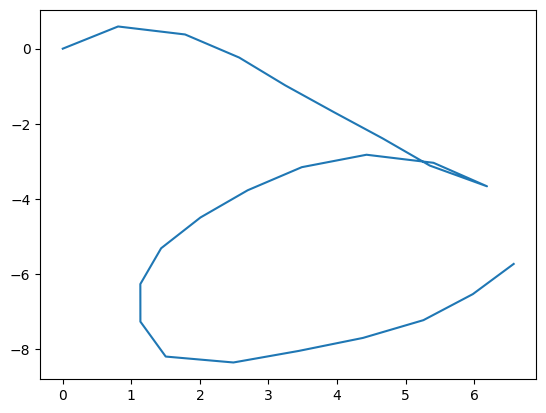

In [4]:
# il s'agit d'un 'a'
tracerLettre(X[0])
print(Y[0]) # vérification de l'étiquette

## A. Apprentissage d'un modèle CM (max de vraisemblance)
### A1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats` (18° si on choisit 20 états)
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`
    - si n_etats = 20 alors [0, 18[ => 0, [18, 36[ => 1, etc...

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [5]:
def discretise(x, d):
    # Votre code :
    intervalle = 360 / d
    
    etats = np.array([np.floor(i/intervalle) for i in x], dtype='object')
    
    return etats

discretise(X[0],3)

array([0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0,
       1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

### A2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [6]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

groupByLabel(Y)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]),
 array([77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]),
 array([88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107]),
 array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117]),
 array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127]),
 array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137]),
 array([138, 139, 140, 141, 142, 143, 144, 145, 146, 147]),
 array([148, 149, 150, 151, 152, 153, 154, 155, 156, 157]),
 array([158, 159, 160, 161, 162, 163, 164, 165, 166, 167]),
 array([168, 169, 170, 171, 172, 173, 174, 175, 176, 177]),
 array([178, 179, 180, 181, 182, 183, 

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe. Il y a donc 11 exemples de 'a'.

### A3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [7]:
def learnMarkovModel(Xc, d):
    # votre code
    # initialisation
    A = np.zeros((d,d))
    Pi = np.zeros(d)
    
    # parcours des signaux
    for x in Xc:
        Pi[int(x[0])] +=1            # comptage de la répartition de chaque classe pour le premier segment (indice 0)
        
        for i in range(len(x)-1):
            A[int(x[i]), int(x[i+1])] +=1        # comptage de la répartition de chaque couple de classe (x_i, x_i+1)

    # normalisation
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1)
    Pi = Pi / Pi.sum()
    
    return Pi, A

# test sur la première classe
learnMarkovModel(discretise(X[0:11], 3),3)

(array([0.36363636, 0.        , 0.63636364]),
 array([[0.84444444, 0.06666667, 0.08888889],
        [0.        , 0.83333333, 0.16666667],
        [0.11382114, 0.06504065, 0.82113821]]))

**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

### A4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [8]:
d = 3                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []

for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[min(index[cl]) : max(index[cl])+1], d))       # modification car Xd[index[cl]] ne foncitonne pas
    
print(models[0])

(array([0.36363636, 0.        , 0.63636364]), array([[0.84444444, 0.06666667, 0.08888889],
       [0.        , 0.83333333, 0.16666667],
       [0.11382114, 0.06504065, 0.82113821]]))


### A5. Distribution stationnaire

La distribution stationnaire $\mu$, pour un système ergodique, correspond à:

- la distribution des états observés dans l'ensemble des données
- la distribution obtenu après un grand nombre de passage dans $A$ à partir de n'importe quelle distribution ou état d'origine (une matrice de transition ergodique va nous permettre de converger)
- la solution de l'équation de stabilité: $\mu = \mu A$

Dans le cas de la lettre 'a' et d'une discrétisation en 3 états, calculer la distribution stationnaire par les deux première méthode et vérifier que vous obtenez des résultats similaires.

**Note 1:** pour la marche aléatoire, vous construirez une boucle sur 100 iérations (borne sup) et vous sortirez dès que la somme des écarts (en absolu) entre $\mu_t$ et $\mu_{t+1}$ est inférieure à $10^{-3}$. Vous vérifierez ensuite que le système converge quelque soit l'état de départ (3 appel àla fonction) ou avec une initialisation aléatoire.

**Note 2:** les deux approches, bien que reposant sur les mêmes données, vont donner des solutions différentes. En effet, il n'y a que peu d'observations et le premier calcul repose sur les états alors que le second repose sur les transitions. 
Afin de vérifier l'exactitude de votre code, vous pourrez revenir sur cette question en fin de sujet avec le protocole suivant:
1. utiliser la matrice de transition de 'a' pour générer une séquence de longeur 100000
1. faire les statistiques des états (à l'aide d'un ```Counter``` par exemple)
1. vérifier la convergence sur de longues séquences

In [9]:
### Methode 1



### Methode 2

def distrib_stationnaire2(X,d,cl, base, borneSup = 20):
    Xd = discretise(X, d)         # discrétisation en d états
    index = groupByLabel(Y)[cl]        # récupération des index de la classe cl
    
    n = 0
    Pi, A = learnMarkovModel(Xd[min(index) : max(index)+1], d)        # calcul de A et de Pi
    
    mu = base
    mu_t = np.matmul(mu,A)         # calcul de la première itération mu_1 = mu_0*A

    # 
    while (n<borneSup and abs(mu - mu_t).sum()>1e-5):
        mu = mu_t
        mu_t = np.matmul(mu,A)
        n+=1

    return mu

# lettre 'a' : classe 0 et discrétisation en 3 étapes
# on considère qu'on commence soit par un angle de la classe 0, 1 ou 2
print(distrib_stationnaire2(X, 3, 0, [1,0,0], 100))
print(distrib_stationnaire2(X, 3, 0, [0,1,0], 100))
print(distrib_stationnaire2(X, 3, 0, [0,0,1], 100))

[0.30304947 0.28282249 0.41412804]
[0.3030092  0.28283541 0.41415539]
[0.30304789 0.28282158 0.41413053]


##  B. Test (affectation dans les classes sur critère MV)
### B1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [10]:
def probaSequence(s, Pi, A):
    # Votre code
    # probabilité au point de départ; selon l'état discret du premier angle, on considère la valeur de Pi appropriée
    log_p = np.log(Pi[ int(s[0]) ])
    
    # selon l'angle suivant, on ajoute la probabilité du couple discret (car on est en log)
    for i in range(len(s)-1):
        log_p += np.log(A[int(s[i]), int(s[i+1])])
    
    return log_p


**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

### B2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [11]:
# On recalcule pour le test qu'on veut
d = 3                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []

for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[min(index[cl]) : max(index[cl])+1], d))       # modification car Xd[index[cl]] ne foncitonne pas

# une ligne pour une classe, une colonne pour chaque série d'angles
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

print(proba[:,0])        # on veut regarder le premier signal pour la première classe

/tmp/ipykernel_8574/723505908.py:4: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(Pi[ int(s[0]) ])
/tmp/ipykernel_8574/723505908.py:8: RuntimeWarning: divide by zero encountered in log
  log_p += np.log(A[int(s[i]), int(s[i+1])])


[-13.491086           -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
 -12.48285678]


### B3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [12]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

0.6902985074626866

**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

## C. Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [13]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [14]:
itrain

[array([ 5,  7,  6,  0,  8,  2,  4, 10]),
 array([16, 20, 11, 13, 12, 18, 21, 17]),
 array([32, 23, 31, 24, 27, 26, 30, 29]),
 array([39, 43, 42, 35, 37, 36, 38, 41]),
 array([49, 44, 48, 47, 54, 53, 46, 45]),
 array([56, 60, 61, 59, 55, 64, 63, 58]),
 array([76, 71, 66, 69, 73, 68, 70, 75]),
 array([82, 77, 85, 79, 87, 86, 78, 80]),
 array([93, 91, 88, 89, 97, 95, 90, 96]),
 array([107, 101, 103, 102,  99,  98, 105, 106]),
 array([117, 114, 112, 108, 116, 115, 109, 111]),
 array([119, 118, 127, 124, 126, 125, 123, 121]),
 array([136, 134, 133, 128, 131, 137, 130, 129]),
 array([146, 147, 140, 144, 142, 143, 145, 139]),
 array([153, 148, 149, 151, 156, 157, 152, 150]),
 array([161, 165, 167, 166, 162, 163, 160, 164]),
 array([174, 176, 168, 171, 173, 177, 170, 172]),
 array([180, 179, 178, 181, 182, 184, 185, 186]),
 array([191, 190, 194, 192, 193, 195, 188, 189]),
 array([204, 199, 200, 201, 203, 198, 206, 207]),
 array([217, 208, 214, 209, 213, 216, 212, 210]),
 array([221, 226, 224,

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [15]:
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

### C1. Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [16]:
# Votre code
ds = range(3,20)           # paramètres de discrétisation
percent_class_train = []
percent_class_test = []

for d in ds:
    # EVALUATION
    Xd = discretise(X, d)    # application de la discrétisation
    models = []

    for cl in range(len(itrain)): # parcours de toutes les classes et optimisation des modèles
        Xc = []
        for i in itrain[cl]:
            Xc.append(Xd[i])      # on sépare dans Xc les X discret de classe cl

        #on trouve pour chaque classe son couple (Pi(probabilité de départ) , A(matrice de transition))
        models.append(learnMarkovModel(Xc, d))       # on forme le modèle pour Xc


    # ANALYSE
    Xtrain = []
    Xtest = []
    
    # on sépare les signaux de test et d'entrainement
    for i in ia:
        Xtrain.append(Xd[i])
    for i in it:
        Xtest.append(Xd[i])

    # on calcul d'après notre modèle les probas de chaque séquence pour chaque classe
    # (une ligne pour une classe, une colonne pour chaque série d'angles)
    proba_train = np.array([[probaSequence(Xtrain[i], models[cl][0], models[cl][1]) for i in range(len(Xtrain))]
                      for cl in range(len(itrain))])
    proba_test = np.array([[probaSequence(Xtest[i], models[cl][0], models[cl][1]) for i in range(len(Xtest))]
                      for cl in range(len(itrain))])


    # ETUDE
    # calcul d'une version numérique des Y :
    Ynum_train = np.zeros(Y[ia].shape)
    Ynum_test = np.zeros(Y[it].shape)

    for num, char in enumerate(np.unique(Y[ia])):
        Ynum_train[Y[ia] == char] = num
    for num, char in enumerate(np.unique(Y[it])):
        Ynum_test[Y[it] == char] = num

    # Calcul de la classe la plus probable :
    pred_train = proba_train.argmax(0) # max colonne par colonne
    pred_test = proba_test.argmax(0) # max colonne par colonne

    # Calcul d'un pourcentage de bonne classification :
    percent_class_train.append(np.where(pred_train != Ynum_train, 0.,1.).mean())
    percent_class_test.append(np.where(pred_test != Ynum_test, 0.,1.).mean())
    


/tmp/ipykernel_8574/723505908.py:4: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(Pi[ int(s[0]) ])
/tmp/ipykernel_8574/723505908.py:8: RuntimeWarning: divide by zero encountered in log
  log_p += np.log(A[int(s[i]), int(s[i+1])])


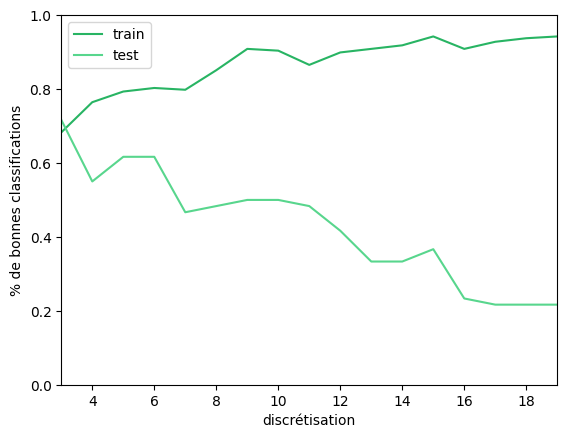

In [17]:
plt.figure()
plt.plot(ds, percent_class_train, '#28B463', label='train')
plt.plot(ds, percent_class_test, '#58D68D', label='test')

plt.axis([min(ds), max(ds), 0, 1])
plt.xlabel('discrétisation')
plt.ylabel('% de bonnes classifications')
plt.legend()

plt.show()

# on trouve la meilleure classification pour une discrétisation entre 3 et 5 états

### C2. Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [18]:
# Votre code
def learnMarkovModel_Ones(Xc, d):
    # votre code
    # initialisation
    A = np.ones((d,d))
    Pi = np.ones(d)
    
    # parcours des signaux
    for x in Xc:
        Pi[int(x[0])] +=1            # comptage de la répartition de chaque classe pour le premier segment (indice 0)
        
        for i in range(len(x)-1):
            A[int(x[i]), int(x[i+1])] +=1        # comptage de la répartition de chaque couple de classe (x_i, x_i+1)

    # normalisation
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1)
    Pi = Pi / Pi.sum()
    
    return Pi, A

#####

percent_class_train_2 = []
percent_class_test_2 = []

for d in ds:
    # EVALUATION
    Xd = discretise(X, d)    # application de la discrétisation
    models = []

    for cl in range(len(itrain)): # parcours de toutes les classes et optimisation des modèles
        Xc = []
        for i in itrain[cl]:
            Xc.append(Xd[i])      # on sépare dans Xc les X discret de classe cl

        #on trouve pour chaque classe son couple (Pi(probabilité de départ) , A(matrice de transition))
        models.append(learnMarkovModel_Ones(Xc, d))       # on forme le modèle pour Xc


    # ANALYSE
    Xtrain = []
    Xtest = []
    
    # on sépare les signaux de test et d'entrainement
    for i in ia:
        Xtrain.append(Xd[i])
    for i in it:
        Xtest.append(Xd[i])

    # on calcul d'après notre modèle les probas de chaque séquence pour chaque classe
    # (une ligne pour une classe, une colonne pour chaque série d'angles)
    proba_train = np.array([[probaSequence(Xtrain[i], models[cl][0], models[cl][1]) for i in range(len(Xtrain))]
                      for cl in range(len(itrain))])
    proba_test = np.array([[probaSequence(Xtest[i], models[cl][0], models[cl][1]) for i in range(len(Xtest))]
                      for cl in range(len(itrain))])


    # ETUDE
    # calcul d'une version numérique des Y :
    Ynum_train = np.zeros(Y[ia].shape)
    Ynum_test = np.zeros(Y[it].shape)

    for num, char in enumerate(np.unique(Y[ia])):
        Ynum_train[Y[ia] == char] = num
    for num, char in enumerate(np.unique(Y[it])):
        Ynum_test[Y[it] == char] = num

    # Calcul de la classe la plus probable :
    pred_train = proba_train.argmax(0) # max colonne par colonne
    pred_test = proba_test.argmax(0) # max colonne par colonne

    # Calcul d'un pourcentage de bonne classification :
    percent_class_train_2.append(np.where(pred_train != Ynum_train, 0.,1.).mean())
    percent_class_test_2.append(np.where(pred_test != Ynum_test, 0.,1.).mean())


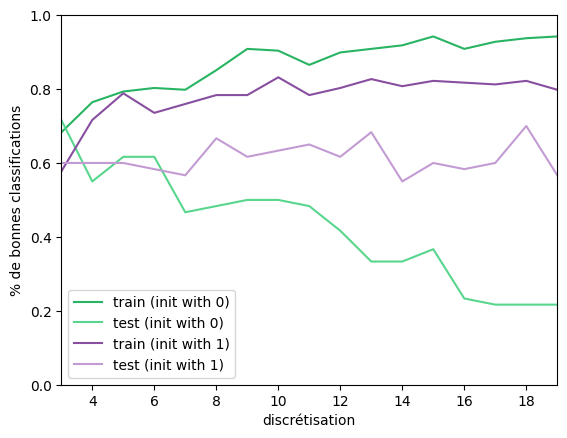

In [19]:
plt.figure()
plt.plot(ds, percent_class_train, '#28B463', label='train (init with 0)')
plt.plot(ds, percent_class_test, '#58D68D', label='test (init with 0)')

plt.plot(ds, percent_class_train_2, '#884EA0', label='train (init with 1)')
plt.plot(ds, percent_class_test_2, '#C39BD3', label='test (init with 1)')

plt.axis([min(ds), max(ds), 0, 1])
plt.xlabel('discrétisation')
plt.ylabel('% de bonnes classifications')
plt.legend()

plt.show()

# En initialisant avec des 1, on obtient globalement de meilleurs résultats sur les tests avec des discrétisations plus grandes

## D. Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [20]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [21]:
# Votre code
# EVALUATION
d = 5                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
models = []

for cl in range(len(itrain)): # parcours de toutes les classes et optimisation des modèles
    Xc = []
    for i in itrain[cl]:
        Xc.append(Xd[i])      # on sépare dans Xc les X discret de classe cl
        
    #on trouve pour chaque classe son couple (Pi(probabilité de départ) , A(matrice de transition))
    models.append(learnMarkovModel(Xc, d))       # on forme le modèle pour Xc

# ANALYSE
Xt = []
for i in it:
    Xt.append(Xd[i])     # on sépare dans Xt les X discret à analyser
    
# on calcul d'après notre modèle les probas de chaque séquence pour chaque classe
# (une ligne pour une classe, une colonne pour chaque série d'angles)
proba = np.array([[probaSequence(Xt[i], models[cl][0], models[cl][1]) for i in range(len(Xt))]
                  for cl in range(len(itrain))])

# ETUDE
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y[it].shape)
for num, char in enumerate(np.unique(Y[it])):
    Ynum[Y[it] == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne


print(pred, "\n", Ynum)


for i in range(len(Ynum)):
    y = int(Ynum[i])
    y_hat = int(pred[i])
    conf[y, y_hat] +=1
    

/tmp/ipykernel_8574/723505908.py:8: RuntimeWarning: divide by zero encountered in log
  log_p += np.log(A[int(s[i]), int(s[i+1])])
/tmp/ipykernel_8574/723505908.py:4: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(Pi[ int(s[0]) ])


[ 0  0  0  1  1  1  2  2  2  3  3  0  4  0  4  5  5  6  6 16 16  7 12  1
 21 10  1  9 18 11 19 19 13 13 13 12 14  0 15 15 16 16 21 21 18 18  7 19
  2 22 21 21 22 22 23 23 24 24 25 25] 
 [ 0.  0.  0.  1.  1.  1.  2.  2.  2.  3.  3.  3.  4.  4.  4.  5.  5.  5.
  6.  6.  6.  7.  7.  7.  8.  8.  9.  9. 10. 10. 11. 11. 12. 12. 13. 13.
 14. 14. 15. 15. 16. 16. 17. 17. 18. 18. 19. 19. 20. 20. 21. 21. 22. 22.
 23. 23. 24. 24. 25. 25.]


- Tracé de la matrice : 

Text(0, 0.5, 'Prédiction')

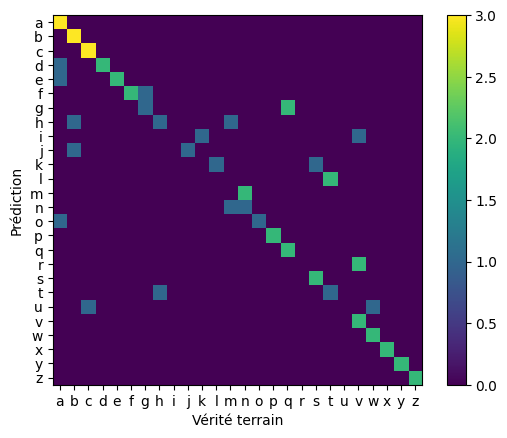

In [22]:
plt.figure()
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
#plt.savefig("mat_conf_lettres.png")

## E. Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### E1. Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### E2. Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [23]:
# Votre code
def generate(Pi, A, l):
    seq = []
    pi_cs = Pi.cumsum()
    x = np.random.random()
    s_i = np.argwhere(x < pi_cs)[0][0]
    seq.append(s_i)
    
    for i in range(1,l):
        A_cs = A[s_i,:].cumsum()
        x = np.random.random()
        s_i = np.argwhere(x < A_cs)[0][0]
        seq.append(s_i)
    
    return seq

d = 20
Xd = discretise(X, d)    # application de la discrétisation
models = []

for cl in range(len(itrain)): # parcours de toutes les classes et optimisation des modèles
    Xc = []
    for i in itrain[cl]:
        Xc.append(Xd[i])      # on sépare dans Xc les X discret de classe cl
        
    #on trouve pour chaque classe son couple (Pi(probabilité de départ) , A(matrice de transition))
    models.append(learnMarkovModel_Ones(Xc, d))       # on forme le modèle pour Xc
    

### E3. Affichage du résultat

[6, 9, 1, 1, 13, 12, 8, 11, 10, 1, 2, 12, 14, 7, 5, 1, 19, 6, 13, 8]


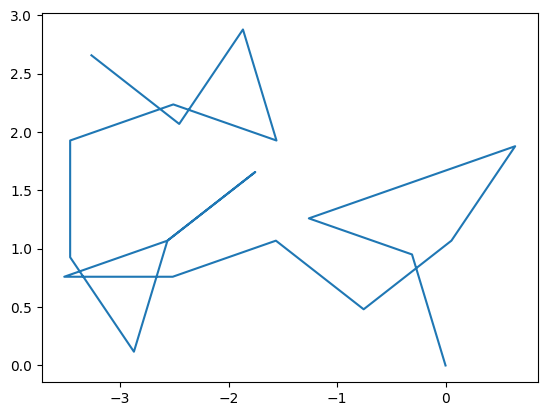

In [24]:
newa = generate(models[0][0], models[0][1], 20)       # generation d'une séquence d'états
intervalle = 360. / d                                 # pour passer des états => valeur d'angles
newa_continu = np.array([i * intervalle for i in newa]) # conv int => double
print(newa)
tracerLettre(newa_continu)

[17, 18, 17, 19, 17, 0, 9, 15, 5, 16]


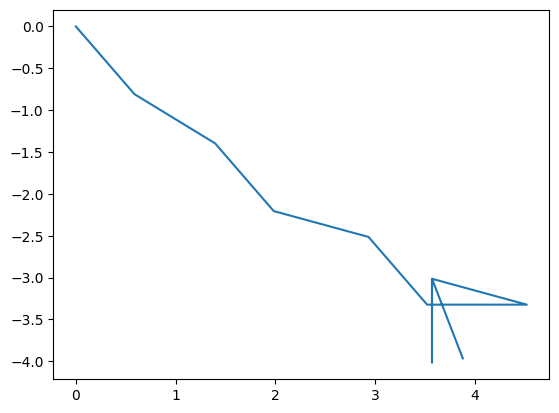

In [25]:
newm = generate(models[18][0], models[18][1], 10)       # generation d'une séquence d'états
intervalle = 360. / d                                 # pour passer des états => valeur d'angles
newm_continu = np.array([i * intervalle for i in newm]) # conv int => double
print(newm)
tracerLettre(newm_continu)